# Conclude Session of Recommondation System

Progress so far:
1. Data Cleaning and Modification
2. Clustering on whole data
3. Data Segmentation based on consistency
4. Deep learning mode on consistent groups

In this page, I'm going to construct a re-cap of my previous work with a clean and clear version. Then made some modification on clustering and data segmentation for the sake of next step's preparation.

The idea includes:
1. Conclude M18 and 19
2. Modify the way of data segmentation (v1-v3)
3. Other algorithms of clustering
4. Confirm how the recommendation system perform
5. Make sure the system is good for new data inputs

In [ ]:
# Read Current Data (M19's way of defining v1, v2, v3
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
svd_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv"
v1_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv"
v2_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv"
v3_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v3.csv"

df = pd.read_csv(full_dataset, encoding="Windows-1252")
df_v1 = pd.read_csv(v1_data, encoding="Windows-1252")
df_v2 = pd.read_csv(v2_data, encoding="Windows-1252")
df_v3 = pd.read_csv(v3_data, encoding="Windows-1252")
df_svd = pd.read_csv(svd_data, encoding="Windows-1252")

## Data Loading and Cleaning

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

In [2]:
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Define trash columns
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']

df = drop_high_nan_columns(df) 
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # age group preparation (modify to int)
df = days_cal_v2(df,'last_visit','first_visit','visit_period')

# # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"
df = one_hot_encode_procedure_and_treatment(df)
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\1647155174.py:2: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\helper_functions.py:40: UserWarning: Could not infer format, so each element will 

- Create a complete dataset to reflect each patient_id's treatment pattern (aassuming all meta columns stand the same for each unique patient id)
- Applied Truncated SVD which is the best for sparse binary data of large sparse matrices.

Note: `final_df` is generated from whole dataset; `df_svd` is based on it. Replace it with any new version of dataset if needed

In [4]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

df_next = df.copy()
# Define Constant columns
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']

# Select relevant columns
base_cols = ['patient_id', 'procedure_age']
procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
df_subset = df_next[base_cols + procedure_cols].copy()
df_subset['procedure_age'] = df_subset['procedure_age'].astype(int) # procedure_age to int

# Melt one-hot to long format
df_long = df_subset.melt(
    id_vars=['patient_id', 'procedure_age'],
    value_vars=procedure_cols,
    var_name='procedure_code',
    value_name='occurred'
)

# Keep only rows where procedure occurred
df_long = df_long[df_long['occurred'] == 1]

# Create combined feature name
df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)

# Pivot to wide format
final_df = df_long.groupby(['patient_id', 'feature']).size().unstack(fill_value=0)
final_df = final_df.reset_index()

# Get metadata (take first row per patient) # may need further fixing if the information for such patient changed over times
patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
final_df = pd.merge(patient_meta, final_df, on='patient_id', how='left')

# columns to exclude from SVD
non_binary_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE','procedure_age', 'visit_period']
meta_df = final_df[non_binary_cols].copy()
binary_df = final_df.drop(columns=non_binary_cols)

# Apply TruncatedSVD on binary columns
X_sparse = csr_matrix(binary_df.values)
svd = TruncatedSVD(n_components=100, random_state=823)
X_svd = svd.fit_transform(X_sparse)
svd_features = pd.DataFrame(X_svd, columns=[f"SVD_{i+1}" for i in range(X_svd.shape[1])])
df_svd = pd.concat([meta_df.reset_index(drop=True), svd_features], axis=1)

In [14]:
df_svd.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv', index=False)

- Dataframe for 17 age groups, start from 5-10, up to 85-90
- Dataframe for each age groups

Note: Change `df` to any version of `dataset` if needed

In [ ]:
import os

# 5 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        lower = (age // 5) * 5
        upper = lower + 5
        if lower > upper:
            return "invalid"
        return f"{lower}-{upper}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe 5 year"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    filename = f"{output_dir}/age_group_{group_name}.csv"
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")


# 1 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        return f"{age}-{age + 1}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe yearly"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

End up with 2 key datasets:   
Dataset 1: Separated datasets which are split by age groups. (5-year or yearly)  
Dataset 2: One complete dataset to contain all treatment history of each patient_id throughout all of their procedure time. (SVD); This is a compact representation of each patient’s historical treatment behavior.  


## Data Segmentation

### Divide patient-level treatment dataset into three groups (V1, V2, V3) based on the continuity and duration of their visit history
Definitions:
- First Visit Date: Start of treatment history
- Last Visit Date: End of treatment history
- Procedure Data: The date which procedure occurred
- Max Gap: Largest time gap between consecutive visits
- Duration: Total time span = Last Visit Date - First Visit Date

V1 (Very Consistent): Max gap between visits is less than 2 years (Doesn’t matter how long the total history is, as long as it's consistent)  
V2 (Inconsistent but Long History): Max gap is 2 years or more; Total duration is 7 years or more  
V3 (Inconsistent and Short History): Everything else

In [14]:
df_next = df.copy() # for next step use
def classify_patient(group):
    procedure_dates = group.sort_values('procedure_date')['procedure_date']
    
    # Visit span in years
    span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

    # Maximum time gap between consecutive visits
    gaps = procedure_dates.diff().dropna().dt.days / 365.0
    max_gap = gaps.max() if not gaps.empty else 0

    # Classification
    if span_years >= 1 and max_gap <= 2:
        return 'V1'
    elif span_years >= 7:
        return 'V2'
    else:
        return 'V3'

# Apply the classification
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']

# Merge version info back to full dataset (Treatment Based)
df_next = df_next.merge(patient_versions, on='patient_id')

C:\Users\frank\AppData\Local\Temp\ipykernel_9708\163003166.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [ ]:
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']

## Unsupervised Learning Recommondation Model

### Clustering data using `df_svd`

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Kmeans
def cluster_patients_kmeans(df_svd, n_clusters=6):
    # Select only the SVD columns
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Add cluster labels to the DataFrame
    df_svd['cluster'] = cluster_labels

    return df_svd, kmeans, scaler


# AgglomerativeClustering
def cluster_patients_agglomerative(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    agglo = AgglomerativeClustering(n_clusters=n_clusters)

    df_svd['cluster'] = agglo.fit_predict(X_scaled)

    return df_svd, agglo, scaler

# GMM
def cluster_patients_gmm(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    df_svd['cluster'] = gmm.fit_predict(X_scaled)

    return df_svd, gmm, scaler

- KMeans baseline  
Baseline clustering model fast and interpretable.  

- Gaussian Mixture Model (GMM) for soft, overlapping patterns  
Patient histories may overlap.  
Can model elliptical clusters, good for reduced features (like SVD).  
Helps find blurry boundaries.  

- Agglomerative Clustering for interpretable structure  
Good for visualizing treatment relationships or creating treatment hierarchies.  
Reveals hierarchical structure — can be useful if patient groups nest within others.  
Good for understanding group similarity.  

Metrics to Evaluate k:  
- Inertia (Elbow Method): How spread out the points are in their clusters
- Silhouette Score: How similar a point is to its own cluster to others

In [ ]:
from sklearn.metrics import silhouette_score

# Kmeans
def grid_search_kmeans(df_svd, svd_prefix='SVD_', k_min=4, k_max=10):
    """
    Performs a grid search over k for KMeans and plots inertia and silhouette scores.
    """
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    k_values = list(range(k_min, k_max + 1))
    inertias = []
    silhouettes = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, marker='o')
    plt.title('Elbow Method: Inertia vs. k')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouettes, marker='o')
    plt.title('Silhouette Score vs. k')
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return k_values, inertias, silhouettes

    from sklearn.mixture import GaussianMixture

# GMM
def grid_search_gmm(df_svd, svd_prefix='SVD_', k_range=range(4, 10)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    scores = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X_scaled)
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1
        scores.append(score)
        print(f"GMM - k={k}, Silhouette Score: {score:.4f}")

    best_k = k_range[scores.index(max(scores))]
    best_model = GaussianMixture(n_components=best_k, random_state=42).fit(X_scaled)
    return best_model, best_k, scores

from sklearn.cluster import AgglomerativeClustering

# Agglomerative
def grid_search_agglomerative(df_svd, svd_prefix='SVD_', k_range=range(4, 10)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = df_svd[svd_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    scores = []
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X_scaled)
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1
        scores.append(score)
        print(f"Agglomerative - k={k}, Silhouette Score: {score:.4f}")

    best_k = k_range[scores.index(max(scores))]
    best_model = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)
    return best_model, best_k, scores


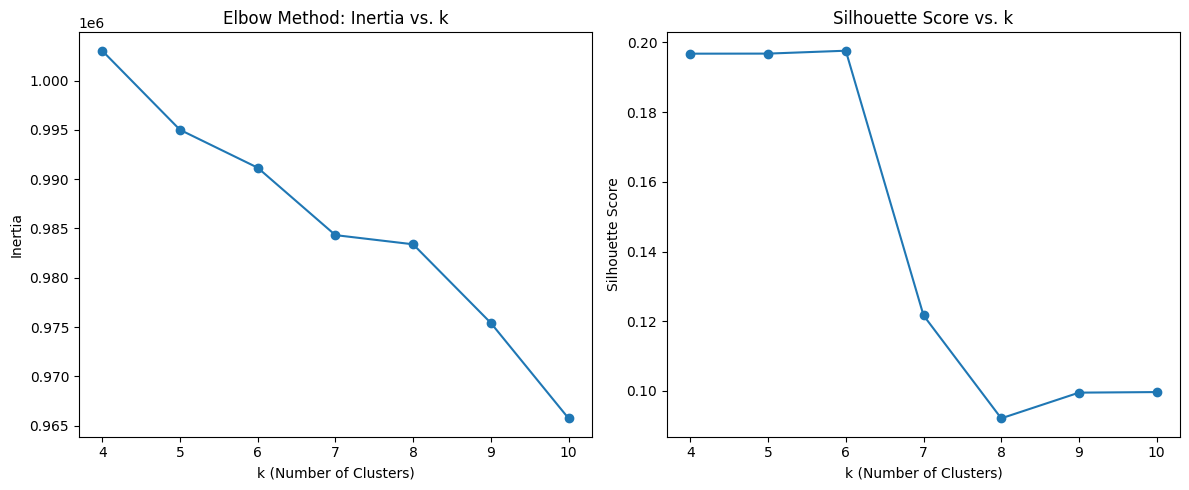

GMM - k=4, Silhouette Score: 0.0163
GMM - k=5, Silhouette Score: -0.0154
GMM - k=6, Silhouette Score: -0.0143
GMM - k=7, Silhouette Score: -0.0461
GMM - k=8, Silhouette Score: -0.0849
GMM - k=9, Silhouette Score: -0.0769
Agglomerative - k=4, Silhouette Score: 0.7889
Agglomerative - k=5, Silhouette Score: 0.7890
Agglomerative - k=6, Silhouette Score: 0.0653
Agglomerative - k=7, Silhouette Score: 0.0662
Agglomerative - k=8, Silhouette Score: 0.0666
Agglomerative - k=9, Silhouette Score: 0.0682


In [ ]:
grid_search_kmeans(df_svd)
best_gmm, best_k_gmm, gmm_scores = grid_search_gmm(df_svd)
best_agg, best_k_agg, agg_scores = grid_search_agglomerative(df_svd)

Kmeans: k = 6  
GMM: k = 4  
Agglomerative: k = 5


In [187]:
df_sv_kmeans, kmeans, scaler = cluster_patients_kmeans(df_svd, n_clusters=6)
cluster_map_kmeans = df_sv_kmeans[['patient_id', 'cluster']]
cluster_map_kmeans

,patient_id,cluster
0,1,3
1,2,4
2,3,3
3,4,3
4,5,3
...,...,...
10253,13579,3
10254,13580,3
10255,13583,3
10256,13584,3


In [191]:
df_sv_gmm, gmm, scaler_gmm = cluster_patients_gmm(df_svd, n_clusters=4)
cluster_map_gmm = df_sv_gmm[['patient_id', 'cluster']]
cluster_map_gmm

,patient_id,cluster
0,1,3
1,2,3
2,3,0
3,4,3
4,5,0
...,...,...
10253,13579,0
10254,13580,0
10255,13583,0
10256,13584,0


In [190]:
df_sv_agg, agg, scaler_agg = cluster_patients_agglomerative(df_svd, n_clusters=5)
cluster_map_agg = df_sv_agg[['patient_id', 'cluster']]
df_sv_agg

,provider_x,amount,treatment_plan_status,patient_id,city,state_y,sikka_provider_id,LATITUDE,LONGITUDE,procedure_age,...,SVD_92,SVD_93,SVD_94,SVD_95,SVD_96,SVD_97,SVD_98,SVD_99,SVD_100,cluster
0,1,663.00,1,1,0,0,0,43.818875,-79.559466,55.693151,...,0.679257,-1.310237,0.418749,-0.268478,-0.459666,-0.326420,1.408708,0.994770,0.192471,0
1,7,77.19,0,2,0,0,0,43.818875,-79.559466,41.287671,...,-0.537491,-1.120165,-1.128762,-1.012749,-0.084358,-0.711287,-0.395388,0.613275,0.074925,0
2,5,19.96,0,3,0,0,0,43.818875,-79.559466,24.797260,...,0.109031,0.210161,0.171720,-0.255636,-0.013390,0.474894,0.300367,-0.243592,0.265608,0
3,7,55.49,0,4,0,0,0,43.835469,-79.555076,15.202740,...,0.409798,-0.146121,-0.312076,-0.171364,0.058218,-1.386143,-0.632145,-0.839857,1.715160,0
4,1,220.00,1,5,0,0,0,43.818875,-79.559466,20.156164,...,0.040611,0.077501,-0.113327,0.063478,0.000552,-0.151971,0.158655,0.031298,0.016163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10253,10,8.75,1,13579,0,0,0,43.838741,-79.563329,10.989041,...,-0.276409,-0.101999,0.251203,0.078569,-0.247758,-0.088183,-0.133617,0.008568,-0.066537,0
10254,10,30.15,1,13580,0,0,0,43.838741,-79.563329,6.621918,...,0.139158,-0.051260,0.559763,-0.378192,0.501527,0.180905,-0.128073,0.051764,-0.046494,0
10255,11,160.14,0,13583,12,0,0,43.840925,-79.551739,8.013699,...,0.026531,0.019474,0.025020,0.052504,0.037267,0.025919,-0.034039,0.031956,-0.011931,0
10256,2,0.00,2,13584,9,0,2,43.671953,-79.399170,39.789041,...,0.026105,-0.016765,-0.005024,0.015098,0.032073,-0.010145,-0.012431,0.015550,0.046990,0


### Add the cluster label from df_svd into each of your 99 age-group files, so every patient in each file knows their cluster.

In [ ]:
import os
def annotate_age_group_files(folder_path, output_path, cluster_map):
    os.makedirs(output_path, exist_ok=True)

    for file in sorted(os.listdir(folder_path)):

        age = int(file.replace("age_group_", "").replace(".csv", ""))
        file_path = os.path.join(folder_path, file)

        # read CSV
        df = pd.read_csv(file_path)

        # Merge with cluster label
        df = df.merge(cluster_map, on='patient_id', how='left')

        # save as CSV
        output_file = os.path.join(output_path, f"age_group_{age}_clustered.csv")
        df.to_csv(output_file, index=False)

    print("All files updated with cluster info.")

In [192]:
folder_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\Split dataframe yearly v1"
output_path_k = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_kmeans"
output_path_gmm = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_gmm"
output_path_agg = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M20\cluster_agg"

annotate_age_group_files(folder_path, output_path_k, cluster_map_kmeans)
annotate_age_group_files(folder_path, output_path_gmm, cluster_map_gmm)
annotate_age_group_files(folder_path, output_path_agg, cluster_map_agg)

All files updated with cluster info.
All files updated with cluster info.
All files updated with cluster info.


### Build Trajectory Dictionary

In [193]:
from collections import defaultdict

def build_trajectory_dict(clustered_folder, procedure_prefix="procedure_code_y_"):
    """
    Create a nested dictionary mapping cluster_id to age to list of top 5 procedure codes.
    """
    # Initialize Nested Dictionary
    trajectory_dict = defaultdict(dict)

    # Goes through each .csv file in the folder
    for file in sorted(os.listdir(clustered_folder)):
        # Extract age from filename
        try:
            age = int(file.replace("age_group_", "").replace("_clustered.csv", "").replace(".csv", ""))
        except ValueError:
            continue

        df = pd.read_csv(os.path.join(clustered_folder, file))
        procedure_cols = [col for col in df.columns if col.startswith(procedure_prefix)]

        for cluster_id in df['cluster'].dropna().unique():
            sub_df = df[df['cluster'] == cluster_id]
            if sub_df.empty:
                continue

            proc_counts = sub_df[procedure_cols].sum().sort_values(ascending=False)
            top_procs = [col.replace(procedure_prefix, "") for col in proc_counts.head(5).index]
            trajectory_dict[int(cluster_id)][age] = top_procs

    return trajectory_dict


In [194]:
trajectory_dict_kmeans = build_trajectory_dict(output_path_k)
trajectory_dict_gmm = build_trajectory_dict(output_path_gmm)
trajectory_dict_agg = build_trajectory_dict(output_path_agg)

Goal: trajectory_dict[cluster_id][age] = ["procedure_code1", "procedure_code2", ...]

In [216]:
trajectory_dict_gmm[2]

{16: ['71101', '72100', '11303', '1011', '51722'],
 18: ['71201', '2142', '51722', '49211', '49219'],
 20: ['12101', '11103', '1103', '2601', '49211'],
 21: ['43413', '2142', '1203', '51722', '49211'],
 22: ['2144', '11113', '1203', '12101', '51922'],
 23: ['11117', '11113', '51711', '43711', '49101'],
 24: ['12101', '11114', '23322', '23321', '1204'],
 25: ['2144', '11114', '1204', '51711', '49101'],
 27: ['2144', '11113', '1204', '12101', '51922'],
 29: ['1202', '2601', '23111', '23311', '2142'],
 30: ['11107', '1204', '2144', '2111', '11112'],
 31: ['11113', '11112', '1204', '1011', '51711'],
 32: ['99111', '14611', '97121', '11113', '11101'],
 33: ['1202', '2114', '1011', '49211', '49219'],
 34: ['11113', '11112', '11101', '1011', '51301'],
 35: ['2114', '11107', '1011', '51711', '49101'],
 36: ['2114', '11113', '11101', '1011', '51301'],
 38: ['1202', '11114', '23323', '12101', '2114'],
 39: ['11117', '11113', '12101', '1202', '2114'],
 40: ['11117', '12101', '11107', '51711', '49

In [212]:
trajectory_dict_kmeans[5]

{29: ['11103', '1103', '12101', '51711', '49101'],
 30: ['43412', '1203', '12101', '23322', '2112'],
 31: ['43412', '2142', '21223', '51711', '49101'],
 32: ['43414', '1203', '23223', '1204', '49211'],
 33: ['2144', '1203', '43413', '43416', '51822'],
 34: ['43413', '2144', '52301', '51711', '49101'],
 37: ['11117', '52301', '43711', '49101', '49211'],
 38: ['23324', '23323', '1011', '52102', '49101'],
 39: ['99111', '11117', '11113', '27211', '12101'],
 40: ['11107', '1011', '51711', '49101', '49211'],
 41: ['12101', '11117', '11113', '11107', '1011'],
 42: ['1202', '1011', '49101', '49211', '49219'],
 43: ['1204', '2601', '11107', '2144', '12101'],
 44: ['11101', '27602', '27201', '20111', '2111'],
 45: ['12101', '1011', '43612', '49101', '49211'],
 46: ['12101', '1011', '43612', '49101', '49211'],
 47: ['2114', '1204', '11114', '11112', '43711'],
 48: ['11113', '11107', '23324', '12101', '11114'],
 49: ['1205', '11114', '11112', '23321', '33121'],
 50: ['11113', '12101', '11107', '2

In [214]:
trajectory_dict_agg[4]

{65: ['2601', '12101', '67211', '11107', '23323'],
 66: ['1202', '1205', '23321', '2114', '51922'],
 67: ['2111', '23324', '23321', '23311', '33111'],
 68: ['11113', '1202', '11117', '23314', '2114'],
 69: ['1202', '2144', '23312', '11113', '23113'],
 70: ['2144', '1202', '49101', '49211', '49219'],
 71: ['1202', '2142', '2112', '51722', '49101'],
 72: ['12111', '1011', '43612', '49101', '49211'],
 73: ['2144', '11113', '12111', '11101', '51301'],
 74: ['2111', '2101', '23324', '1205', '43711'],
 75: ['23311', '43413', '49101', '49211', '49219'],
 76: ['99555', '23114', '99111', '27205', '79932']}

### Weighted Recommendation (Similarity Scoring)

In [228]:
def calculate_similarity(row, target_row, feature_weights):
    score = 0
    for feature, weight in feature_weights.items():
        if feature in row and feature in target_row:
            score += weight * (row[feature] == target_row[feature])
    return score

In [229]:
def recommend_weighted_procedures(
    patient_id,
    current_age,
    df_svd,
    trajectory_dict,
    clustered_folder,
    feature_weights=None,
    procedure_prefix="procedure_code_y_",
    top_n=5):
    
    if feature_weights is None:
        feature_weights = {"city": 1.0, "state": 0.5, "treatment_category": 1.5}

    if patient_id not in df_svd['patient_id'].values:
        return []

    # Get patient metadata and cluster
    patient_info = df_svd[df_svd['patient_id'] == patient_id].iloc[0]
    cluster = patient_info['cluster']
    next_age = current_age + 1

    # Load next age file
    filename = f"age_group_{next_age}_clustered.csv"
    file_path = os.path.join(clustered_folder, filename)

    if not os.path.exists(file_path):
        return []

    df_next = pd.read_csv(file_path)

    # Filter to same cluster
    df_cluster = df_next[df_next['cluster'] == cluster]
    if df_cluster.empty:
        return []

    # Compute similarity scores
    df_cluster = df_cluster.copy()
    df_cluster["similarity"] = df_cluster.apply(lambda row: calculate_similarity(row, patient_info, feature_weights), axis=1)

    # Weight procedure code counts by similarity
    procedure_cols = [col for col in df_cluster.columns if col.startswith(procedure_prefix)]
    weighted_scores = {}

    for _, row in df_cluster.iterrows():
        for col in procedure_cols:
            weighted_scores[col] = weighted_scores.get(col, 0) + row[col] * row["similarity"]

    # Sort by score and return top N (strip prefix)
    sorted_proc = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [col.replace(procedure_prefix, "") for col, _ in sorted_proc[:top_n]]

    return recommendations


In [233]:
recommend_weighted_procedures(
    patient_id=12121,
    current_age=37,
    df_svd=df_sv_gmm,
    trajectory_dict=trajectory_dict_gmm,
    clustered_folder=output_path_gmm
)

['2144', '12111', '1103', '1202', '1204']

### Weighted based on type (consistency)

## Deep Learning (MLP/LSTM) cannot be applied by now as the data is not adqueate